In [112]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import randint as sp_randint
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import skew
from scipy.stats.stats import pearsonr
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.svm import SVR
from sklearn.ensemble import AdaBoostRegressor
from itertools import product
from sklearn.ensemble import VotingClassifier

%matplotlib inline

In [106]:
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")


In [14]:
train = pd.read_csv("../cleanedData/data.train.matrix.csv")
test = pd.read_csv("../cleanedData/data.test.matrix.csv")

In [15]:
y = train['SalePrice']
cols = [col for col in train.columns if col not in ['SalePrice']]
X_train = train[cols]

In [89]:
train = pd.read_csv("../rawData/train.csv")
test = pd.read_csv("../rawData/test.csv")

In [90]:
all_data = pd.concat((train.loc[:,'MSSubClass':'SaleCondition'],
                      test.loc[:,'MSSubClass':'SaleCondition']))
matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)
prices = pd.DataFrame({"price":train["SalePrice"], "log(price + 1)":np.log1p(train["SalePrice"])})
# prices.hist()
#log transform the target:
train["SalePrice"] = np.log1p(train["SalePrice"])

#log transform skewed numeric features:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index

all_data[skewed_feats] = np.log1p(all_data[skewed_feats])
all_data = pd.get_dummies(all_data)
all_data = all_data.fillna(all_data.mean())


X_train = all_data[:train.shape[0]]
X_test = all_data[train.shape[0]:]
y = train.SalePrice


In [91]:
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score

def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

In [92]:
model_ridge = Ridge()

In [93]:
alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
cv_ridge = [rmse_cv(Ridge(alpha = alpha)).mean() 
            for alpha in alphas]

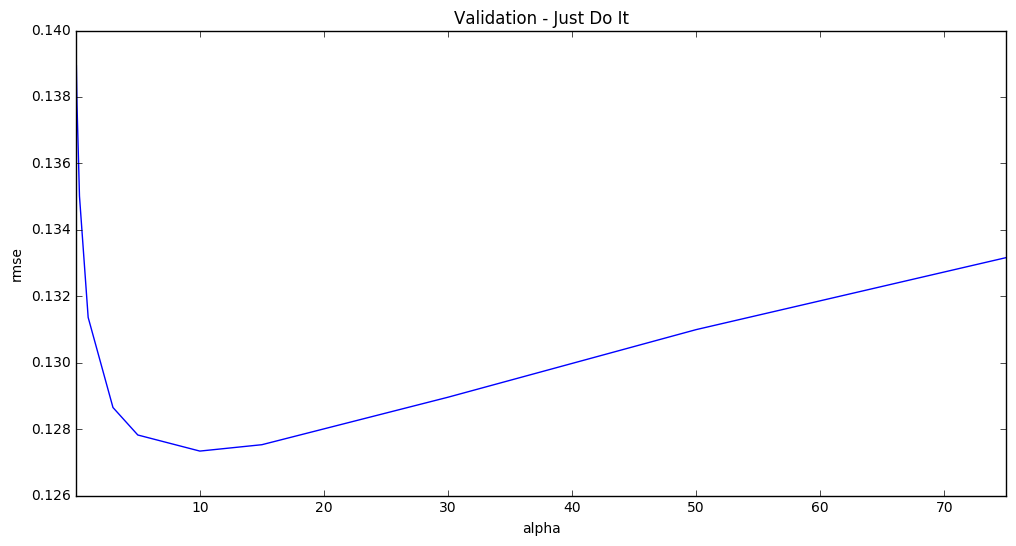

In [94]:
cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = "Validation - Just Do It")
plt.xlabel("alpha")
plt.ylabel("rmse")

In [95]:
cv_ridge.min()

0.12733734668670754

In [96]:
model_lasso = LassoCV(alphas = [1, 0.5, 0.1, 0.005, 0.001, 0.0005]).fit(X_train, y)

In [136]:
param_bundle = {
    
    'randomForest': {
        "max_depth": [None], 
        "n_estimators": [2000],
        'n_jobs':[-1]
    },
    'gbm': {
        "max_depth": [None], 
        "n_estimators": [1000],
        "learning_rate": [0.1, 0.05, 0.001]
    }
    
}

In [137]:
model_bundle = {
    'randomForest': RandomForestRegressor,
    'gbm': GradientBoostingRegressor
    
}

In [ ]:
for key, val in param_bunble.items():
    param_grid = param_bundle[key]
    model = model_bundle[key]()
#     clf = model(param)
    grid_search = GridSearchCV(model, param_grid=param_grid, n_jobs = -1, cv= 8)
    grid_search.fit(X_train, y)
    report(grid_search.cv_results_)
    cv_result = rmse_cv(grid_search)
    print(cv_result.mean())

In [127]:
clf = GradientBoostingRegressor(n_estimators=500)

param_grid = {"max_depth": [3, 5, None], "learning_rate": [0.1, 0.05, 0.001]}    
# run grid search
grid_search = GridSearchCV(clf, param_grid=param_grid, n_jobs = -1, cv= 8)

grid_search.fit(X_train, y)

GridSearchCV(cv=8, error_score='raise',
       estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_split=1e-07,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=200,
             presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'learning_rate': [0.1, 0.05], 'max_depth': [1, 3]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [123]:
report(grid_search.cv_results_)

Model with rank: 1
Mean validation score: 0.906 (std: 0.016)
Parameters: {'learning_rate': 0.1, 'max_depth': 3}

Model with rank: 2
Mean validation score: 0.902 (std: 0.015)
Parameters: {'learning_rate': 0.05, 'max_depth': 3}

Model with rank: 3
Mean validation score: 0.884 (std: 0.018)
Parameters: {'learning_rate': 0.1, 'max_depth': 1}



In [124]:
cv_rf = rmse_cv(grid_search)

In [125]:
cv_rf.mean()

0.12351818469983225

In [98]:
learning_rates = [0.05, 0.1]
cv_gbm = [rmse_cv(GradientBoostingRegressor(n_estimators= 500, learning_rate = learning_rate)).mean() 
            for learning_rate in learning_rates]
cv_gbm = pd.Series(cv_gbm, index = learning_rates)

In [99]:
cv_gbm.min()

0.12565536164521188

In [100]:
rmse_cv(clf1).mean()

0.14947375045778705

In [52]:
np.exp(model_lasso.predict(X_test)) - 1

array([ 119958.03568086,  151482.56732178,  180200.85364774, ...,
        169023.5480817 ,  118942.41768702,  228403.15457007])

In [81]:
# X_train['SalePrice']

In [75]:
# X_train.to_csv("../cleanedData/data.train.matrix2.csv")